# NodeNorm Log Analysis

As of [PR #312](https://github.com/TranslatorSRI/NodeNormalization/pull/312), NodeNorm produces logs in the format:

```
2025-06-18T03:26:30-04:00	2025-06-18 07:26:30,635 | INFO | normalizer:get_normalized_nodes | Normalized 1 nodes in 1.21 ms with arguments (curies=['UMLS:C0132098'], conflate_gene_protein=True, conflate_chemical_drug=True, include_descriptions=False, include_individual_types=True)
```

This Jupyter Notebook is intended to be used in analysing these logs.

## Install prerequisites

In [1]:
import csv
%pip install pandas matplotlib numpy seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Loading files

These files can be checked into the repository into the `logs/` subdirectory.

In [2]:
logfiles_json_gz = [
    "https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jul3-10k.json.gz",
    "https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jun26-to-2025jun29.json.gz"
]

We can use Python dataclasses to load the important information from the logfile.

In [3]:
import json
from dataclasses import dataclass
from datetime import datetime
import csv
import gzip
import logging
import re
import ast

logging.basicConfig(level=logging.INFO)

@dataclass
class LogEntry:
    time: datetime
    curies: list[str]
    curie_count: int
    time_taken_ms: float
    time_taken_per_curie_ms: float
    arguments: dict[str, str]
    node: str = ""

def convert_log_line_into_entry(line: str) -> list[LogEntry]:
    # Depending on where the log file comes from, it might start with one of two types of timestamps:
    # - ISO 8601 date (e.g. "2007-04-05T12:30−02:00"), which will be separated from the rest of the log line with a tab character.
    # - Python log format date (e.g. "2025-06-12 13:01:49,319"), which should always be in UTC.

    # Entry variables.
    log_time = None
    curies = []
    curie_count = -1
    time_taken_ms = -1.0
    arguments = {}

    # Parse the datetime stamp.
    iso8601date_match = re.match(r'^(\d{4}-\d{2}-\d{2}(?:[T ]\d{2}:\d{2}(?::\d{2}(?:[\.,]\d+)?(?:Z|[+-]\d{2}:\d{2})?)?)?) |', line)
    if iso8601date_match:
        log_time = datetime.fromisoformat(iso8601date_match.group(1))
    else:
        raise ValueError(f"Could not identify the datetime for the line: '{line}'")

    # Is the log line too long?
    if len(line) > 81_900: # Longest we've seen is 114688, and that was truncated.
        return []

    # Parse the log text.
    log_text_match = re.search(r'\| INFO \| normalizer:get_normalized_nodes \| Normalized (\d+) nodes in ([\d\.]+) ms with arguments \((.*)\)', line)
    if not log_text_match:
        raise ValueError(f"Could not find NodeNorm log-line (length: {len(line)}): {line}")
    curie_count = int(log_text_match.group(1))
    time_taken_ms = float(log_text_match.group(2))
    argument_text = log_text_match.group(3)

    # To parse the argument_text, we can turn it into a function call and use Python's ast module to parse it.
    argument_fn_call = f'arguments({argument_text})'
    tree = ast.parse(argument_fn_call, mode="eval")
    call_node = tree.body
    for kw in call_node.keywords:
        arguments[kw.arg] = ast.literal_eval(kw.value)

    # Some assertions.
    if 'curies' not in arguments:
        raise ValueError(f'No CURIEs found in arguments {argument_text} on line {line}, which was parsed into: {arguments}')
    curies = arguments['curies']
    if len(curies) != curie_count:
        raise ValueError(f'Found {len(curies)} CURIEs in arguments but expected {curie_count} CURIEs: {curies}')
    if len(curies) < 1:
        raise ValueError(f'Found no CURIEs in line: {line}')

    # Emit the LogEntry.
    return [LogEntry(
        time=log_time,
        curies=curies,
        curie_count=curie_count,
        time_taken_ms=time_taken_ms,
        time_taken_per_curie_ms=time_taken_ms/curie_count,
        arguments=arguments
    )]

In [4]:
import urllib
import io

logs = []
for logfile_json_gz in logfiles_json_gz:
    print(f"Loading logfile {logfile_json_gz}")

    with urllib.request.urlopen(logfile_json_gz) as response:
        with gzip.open(io.BytesIO(response.read()), 'rt', encoding='utf-8') as logf:
            # The entire log file from AWS is one massive JSON list *curses*.
            data = json.load(logf)
            for row in data:
                # print(f"Processing row: {row}")

                # Weirdly enough, AWS logs are wrapped in TWO layers:
                message = row['@message']
                if isinstance(message, dict):
                    line = row['@message']['log']
                else:
                    # This will probably (?) be an incomplete log line, so let's skip it.
                    continue

                # We're only interested in log-lines -- these will all contain `normalizer:get_normalized_nodes`
                if "normalizer:get_normalized_nodes" not in line:
                    continue

                logs.extend(convert_log_line_into_entry(line))

    print(f"Loaded {len(logs)} log entries from {logfile_json_gz}")

Loading logfile https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jul3-10k.json.gz
Loaded 9992 log entries from https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jul3-10k.json.gz
Loading logfile https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jun26-to-2025jun29.json.gz
Loaded 19043 log entries from https://stars.renci.org/var/babel_outputs/nodenorm-logs/nodenorm-ci-logs-2025jun26-to-2025jun29.json.gz


In [5]:
logs[0:10]

[LogEntry(time=datetime.datetime(2025, 7, 3, 14, 1, 4, 186000), curies=['CHEMBL.COMPOUND:CHEMBL112', 'UniProtKB:P05177', 'UniProtKB:O43570', 'UniProtKB:P00918', 'UniProtKB:P00915', 'UniProtKB:P07451', 'UniProtKB:P35218', 'UniProtKB:Q9Y2D0', 'UniProtKB:P23280', 'UniProtKB:P22748', 'UniProtKB:P43166', 'UniProtKB:Q16790', 'UniProtKB:Q9ULX7', 'UniProtKB:P20292', 'UniProtKB:P51589', 'UniProtKB:P02144', 'UniProtKB:P35354', 'UniProtKB:P23219', 'UniProtKB:O15438', 'UniProtKB:O95342', 'UniProtKB:P10635', 'UniProtKB:P08684', 'UniProtKB:O15439', 'UniProtKB:Q92887', 'UniProtKB:P04798'], curie_count=25, time_taken_ms=48.27, time_taken_per_curie_ms=1.9308, arguments={'curies': ['CHEMBL.COMPOUND:CHEMBL112', 'UniProtKB:P05177', 'UniProtKB:O43570', 'UniProtKB:P00918', 'UniProtKB:P00915', 'UniProtKB:P07451', 'UniProtKB:P35218', 'UniProtKB:Q9Y2D0', 'UniProtKB:P23280', 'UniProtKB:P22748', 'UniProtKB:P43166', 'UniProtKB:Q16790', 'UniProtKB:Q9ULX7', 'UniProtKB:P20292', 'UniProtKB:P51589', 'UniProtKB:P02144'

# Some overall measures

In [32]:
times = sorted(list(set(map(lambda x: x.time, logs))))
count_requests = len(logs)
unique_curies = sorted(set([x for xs in map(lambda x: x.curies, logs) for x in xs]))

print(f"Time range: {times[0]} to {times[-1]} ({times[-1] - times[0]})")
print(f"Total number of requests: {count_requests}")
print(f"Total number of CURIEs: {sum(map(lambda x: x.curie_count, logs))}")
print(f"Total time taken: {sum(map(lambda x: x.time_taken_ms, logs))} ms")
print(f"Average time per request: {sum(map(lambda x: x.time_taken_ms, logs))/count_requests} ms")
print(f"Average time per CURIE: {sum(map(lambda x: x.time_taken_per_curie_ms, logs))/count_requests} ms")
print(f"Total number of unique CURIEs: {len(unique_curies)}")

Time range: 2025-06-26 00:01:03.559000 to 2025-07-03 14:01:04.186000 (7 days, 14:00:00.627000)
Total number of requests: 19043
Total number of CURIEs: 2176206
Total time taken: 6709482.9 ms
Average time per request: 352.33329307357036 ms
Average time per CURIE: 5.6768893532676605 ms
Total number of unique CURIEs: 233697


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import asdict

# Assume `records` is your list of dataclass instances
# Convert to DataFrame
df = pd.DataFrame([asdict(r) for r in logs])
df['time'] = pd.to_datetime(df['time'])
df['throughput_cps'] = df['curie_count'] / df['time_taken_ms'] * 1000
print(f"Throughput: {df['throughput_cps'].mean()} CURIES per second")

Throughput: 454.24311040513027 CURIES per second


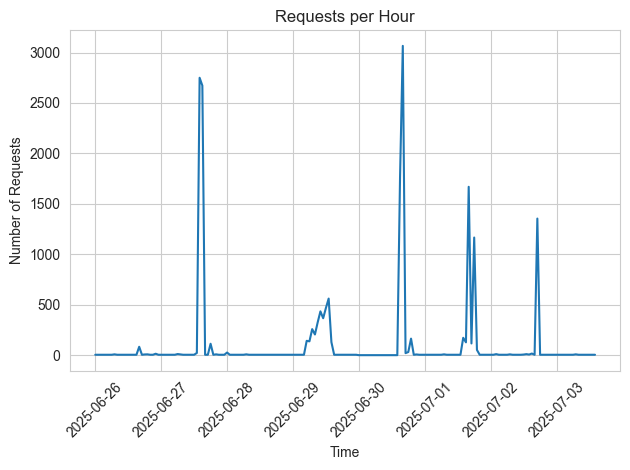

In [8]:
# Plot requests against time.
requests_per_hour = df.set_index('time').resample('h').size()
sns.lineplot(x=requests_per_hour.index, y=requests_per_hour.values)
plt.title("Requests per Hour")
plt.xlabel("Time")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

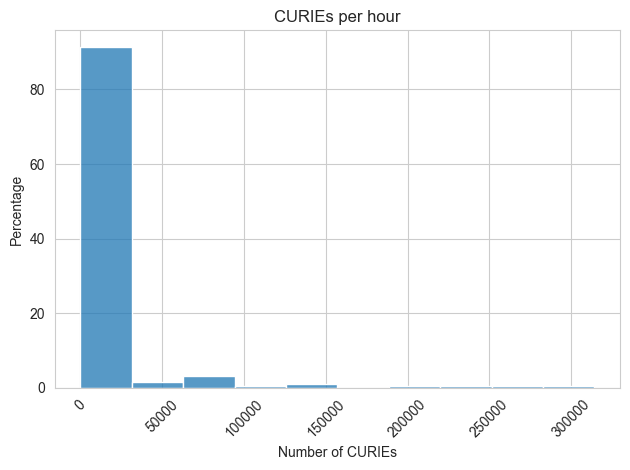

In [56]:
# Plot the frequency distribution of CURIE counts grouped by hour.
curies_per_hour = df.set_index('time').resample('h')['curie_count'].sum()
sns.histplot(curies_per_hour, bins=10, stat='percent')
plt.title("CURIEs per Hour")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("CURIEs per hour")
plt.xlabel("Number of CURIEs")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()

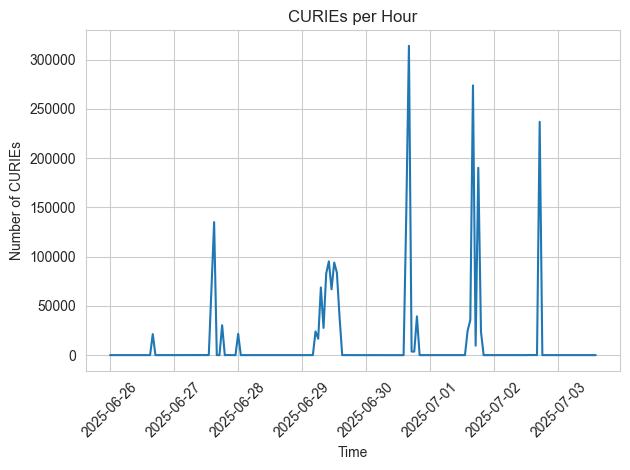

In [16]:
# Plot CURIEs over time (by hour)
curies_per_hour = df.set_index('time').resample('h')['curie_count'].sum()
sns.lineplot(x=curies_per_hour.index, y=curies_per_hour.values)
plt.title("CURIEs per Hour")
plt.xlabel("Time")
plt.ylabel("Number of CURIEs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


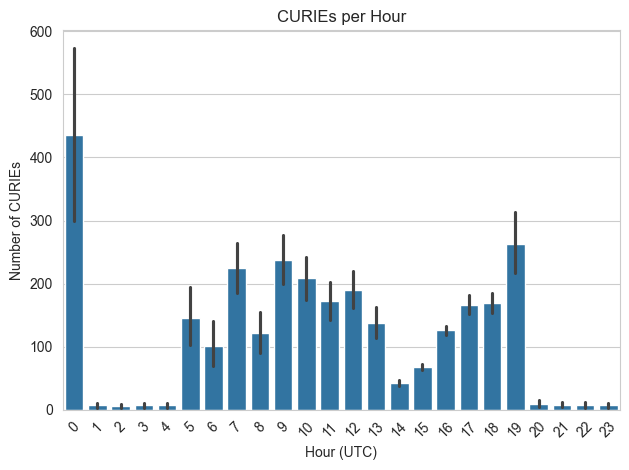

In [27]:
# Plot CURIEs against hour of day
df['hour_of_day'] = df['time'].dt.hour
sns.barplot(x=df['hour_of_day'], y=df['curie_count'])
plt.title("CURIEs per Hour")
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of CURIEs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

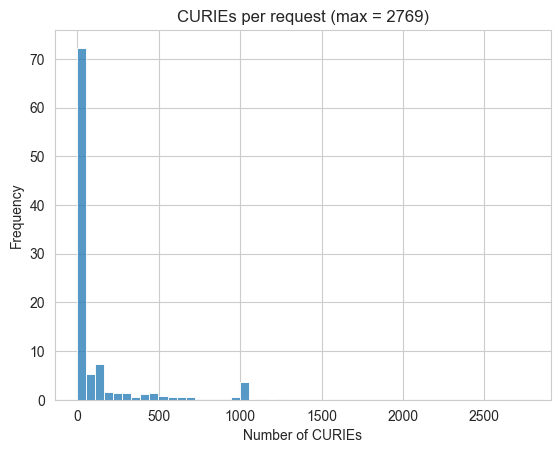

In [9]:
# CURIEs per request
sns.histplot(df['curie_count'], bins=50, stat='percent')
plt.title(f"CURIEs per request (max = {max(df['curie_count'])})")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.show()

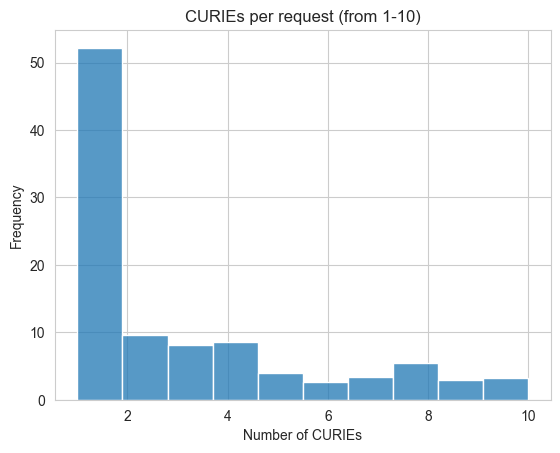

In [10]:
# CURIEs per request (but only from 1-10)
sns.histplot(df['curie_count'], bins=10, binrange=(1, 10), stat='percent')
plt.title("CURIEs per request (from 1-10)")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.show()

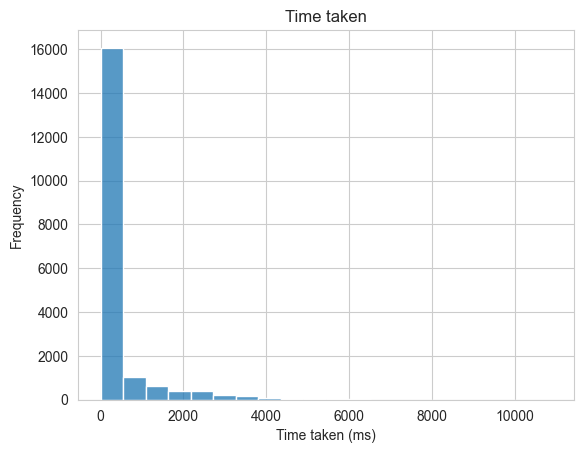

In [11]:
# Time taken distribution
sns.histplot(df['time_taken_ms'], bins=20)
plt.title("Time taken")
plt.xlabel("Time taken (ms)")
plt.ylabel("Frequency")
plt.show()

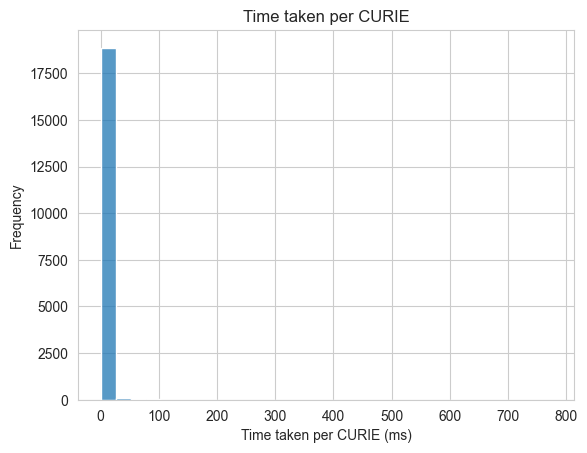

In [12]:
# Time per CURIE distribution
# CURIEs per request
sns.histplot(df['time_taken_per_curie_ms'], bins=30)
plt.title("Time taken per CURIE")
plt.xlabel("Time taken per CURIE (ms)")
plt.ylabel("Frequency")
plt.show()